# 0. Imports and setup

## 0.1. Install Jax

In [0]:
!pip install --upgrade -q https://storage.googleapis.com/jax-releases/cuda$(echo $CUDA_VERSION | sed -e 's/\.//' -e 's/\..*//')/jaxlib-0.1.27-cp36-none-linux_x86_64.whl
!pip install --upgrade -q jax

In [0]:
!echo $CUDA_VERSION

10.0.130


## 0.2. Get Freesolv and pre-computed configuration snapshots

In [0]:
!nvidia-smi

Thu Aug 29 19:10:32 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0    31W /  70W |  13755MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
!curl -O https://github.com/openforcefield/bayes-implicit-solvent/raw/fb54fda2ac1a079143b59476153b2be33214244e/bayes_implicit_solvent/continuous_parameter_experiments/gd_vs_langevin/freesolv_inputs.pkl

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   269  100   269    0     0   1222      0 --:--:-- --:--:-- --:--:--  1222


In [0]:
from pickle import load

with open('freesolv_inputs.pkl', 'rb') as f:
  freesolv_inputs = load(f)
print(list(freesolv_inputs.keys()))

# load from dictionary
distance_matrices = freesolv_inputs['distance_matrices'] # list of (25,n_atoms_i,n_atoms_i) arrays
print('distance_matrices[0].shape', distance_matrices[0].shape)
type_slices = freesolv_inputs['type_slices']
charges = freesolv_inputs['charges']
n_types = freesolv_inputs['n_types']

['distance_matrices', 'expt_means', 'expt_uncertainties', 'type_slices', 'charges', 'n_types']
distance_matrices[0].shape (25, 17, 17)


# 0.3. Thinning

In [0]:
from tqdm import tqdm
mol_thinning = 1
snapshot_thinning = 1


distance_matrices = [d[::snapshot_thinning] for d in tqdm(distance_matrices[::mol_thinning])]
type_slices = [t for t in tqdm(type_slices[::mol_thinning])]
charges = [c for c in tqdm(charges[::mol_thinning])]
expt_means = freesolv_inputs['expt_means'][::mol_thinning]
expt_uncertainties = freesolv_inputs['expt_uncertainties'][::mol_thinning]

print('distance_matrices[0].shape', distance_matrices[0].shape)

100%|██████████| 631/631 [00:00<00:00, 801758.81it/s]

distance_matrices[0].shape (25, 17, 17)


## 0.4. (Optional) Move to device

In [0]:

from jax import device_put


# move to device
distance_matrices = list(map(device_put, distance_matrices))
type_slices = list(map(device_put, type_slices))
charges = list(map(device_put, charges))
expt_means = device_put(expt_means)
expt_uncertainties = device_put(expt_uncertainties)


# 1. Molecular mechanics

## 1.1. Energy function

In [0]:
import jax.numpy as np
from jax import grad, jit

@jit
def step(x):
    # return (x > 0)
    return 1.0 * (x >= 0)

@jit
def compute_OBC_energy_vectorized(distance_matrix, radii, scales, charges,
                                  offset=0.009, screening=138.935484, surface_tension=28.3919551,
                                  solvent_dielectric=78.5, solute_dielectric=1.0,
                                  ):
    """Compute GBSA-OBC energy from a distance matrix"""
    N = len(radii)
    #print(type(distance_matrix))
    eye = np.eye(N, dtype=distance_matrix.dtype)
    #print(type(eye))
    r = distance_matrix + eye # so I don't have divide-by-zero nonsense
    or1 = radii.reshape((N, 1)) - offset
    or2 = radii.reshape((1, N)) - offset
    sr2 = scales.reshape((1, N)) * or2

    L = np.maximum(or1, abs(r - sr2))
    U = r + sr2
    I = step(r + sr2 - or1) * 0.5 * (
            1 / L - 1 / U + 0.25 * (r - sr2 ** 2 / r) * (1 / (U ** 2) - 1 / (L ** 2)) + 0.5 * np.log(
        L / U) / r)

    I -= np.diag(np.diag(I))
    I = np.sum(I, axis=1)

    # okay, next compute born radii
    offset_radius = radii - offset
    psi = I * offset_radius
    psi_coefficient = 0.8
    psi2_coefficient = 0
    psi3_coefficient = 2.909125

    psi_term = (psi_coefficient * psi) + (psi2_coefficient * psi ** 2) + (psi3_coefficient * psi ** 3)

    B = 1 / (1 / offset_radius - np.tanh(psi_term) / radii)

    # finally, compute the three energy terms
    E = 0.0

    # single particle
    E += np.sum(surface_tension * (radii + 0.14) ** 2 * (radii / B) ** 6)
    E += np.sum(-0.5 * screening * (1 / solute_dielectric - 1 / solvent_dielectric) * charges ** 2 / B)

    # particle pair
    f = np.sqrt(r ** 2 + np.outer(B, B) * np.exp(-r ** 2 / (4 * np.outer(B, B))))
    charge_products = np.outer(charges, charges)

    E += np.sum(np.triu(-screening * (1 / solute_dielectric - 1 / solvent_dielectric) * charge_products / f, k=1))

    return E


In [0]:
# call once on each molecule, since each n_atoms is separately JIT'd...

for i in tqdm(range(len(distance_matrices))):
    distance_matrix = distance_matrices[i][0]
    n = len(distance_matrix)
    compute_OBC_energy_vectorized(distance_matrix, np.ones(n), np.ones(n), np.ones(n))

100%|██████████| 631/631 [00:30<00:00, 20.61it/s]


## 1.2. Free energy as a function of parameters

In [0]:
kj_mol_to_kT = 0.40339497740718383

from jax import vmap
from jax.scipy.special import logsumexp

def one_sided_exp(w_F):
  return - (logsumexp(- w_F) - np.log(len(w_F)))

theta = np.hstack((np.ones(n_types), np.ones(n_types)))

def unpack(theta):
    radii_, scaling_factors_ = theta[:n_types], theta[n_types:]
    return 0.1 * radii_, scaling_factors_

@jit
def predict_solvation_free_energy_jax(theta, distance_matrices, charges, type_slice):
    radii_, scaling_factors_ = unpack(theta)

    radii, scaling_factors = radii_[type_slice], scaling_factors_[type_slice]

    def compute_component(distance_matrix):
        return compute_OBC_energy_vectorized(distance_matrix, radii, scaling_factors, charges)

    W_F = vmap(compute_component)(distance_matrices)
    w_F = W_F * kj_mol_to_kT
    return one_sided_exp(w_F)


@jit
def get_predictions(theta):
    """Produce predictions for all molecules in the freesolv set"""
    return np.array([predict_solvation_free_energy_jax(theta, distance_matrices[i], charges[i], type_slices[i]) for i in range(len(distance_matrices))])
# TODO: Replace with vmap?


In [0]:
kj_mol_to_kcal_mol = 0.2390057361376673
kT_to_kcal_mol = (1.0 / kj_mol_to_kT) * kj_mol_to_kcal_mol
kT_to_kcal_mol

0.5924856518389834

### 1.2.1. Benchmarking cost of constructing the predictions

In [0]:
%%time

# first run
preds = get_predictions(theta)

CPU times: user 379 ms, sys: 12.3 ms, total: 391 ms
Wall time: 391 ms


In [0]:
%%time

# second run
preds = get_predictions(theta)

CPU times: user 34.4 ms, sys: 7.03 ms, total: 41.5 ms
Wall time: 40.6 ms


# 2. Bayesian model

## 2.1. Prior

In [0]:
def uniform_log_prior(theta, r_bounds=(1e-5, 5), s_bounds=(-10,10)):
    radii, scales = unpack(theta)
    n = len(radii)
    r_in_bounds = (min(radii) >= r_bounds[0]) and (max(radii) <= r_bounds[1])
    s_in_bounds = (min(scales) >= s_bounds[0]) and (max(scales) <= s_bounds[1])
    if r_in_bounds and s_in_bounds:
        return - np.log(n*(r_bounds[1] - r_bounds[0])) - np.log(n * (s_bounds[1] - s_bounds[0]))
    else:
        return - np.inf

## 2.2. Likelihood

In [0]:
from jax.scipy.stats import norm


@jit
def log_likelihood_as_fxn_of_prediction(prediction, expt_mean, expt_uncertainty):
    return norm.logpdf(prediction, loc=expt_mean, scale=expt_uncertainty)

@jit
def compute_log_likelihood_component(theta, distance_matrix_array, charge_array, type_slice_array, expt_mean, expt_uncertainty):
    prediction = predict_solvation_free_energy_jax(theta, distance_matrix_array, charge_array, type_slice_array)
    return log_likelihood_as_fxn_of_prediction(prediction, expt_mean, expt_uncertainty)

In [0]:
i = 0
compute_log_likelihood_component(theta, distance_matrices[i], charges[i], type_slices[i], expt_means[i], expt_uncertainties[i])

DeviceArray(-17223.29, dtype=float32)

In [0]:
g_component = jit(grad(compute_log_likelihood_component))

In [0]:
%%time
_ = g_component(theta, distance_matrices[i], charges[i], type_slices[i], expt_means[i], expt_uncertainties[i])

CPU times: user 847 ms, sys: 159 ms, total: 1.01 s
Wall time: 1.58 s


In [0]:
%%time
_ = g_component(theta, distance_matrices[i], charges[i], type_slices[i], expt_means[i], expt_uncertainties[i])

CPU times: user 4.23 ms, sys: 9 µs, total: 4.24 ms
Wall time: 4.21 ms


In [0]:
all_inds = np.arange(len(distance_matrices))
n_batches = 5
# todo: make this less janky!
inds_0 = all_inds[0::n_batches]
inds_1 = all_inds[1::n_batches]
inds_2 = all_inds[2::n_batches]
inds_3 = all_inds[3::n_batches]
inds_4 = all_inds[4::n_batches]


@jit
def compute_grad_log_likelihood_w_loop_0(theta):
    g = np.zeros(len(theta))
    for i in inds_0:
        g += g_component(theta, distance_matrices[i], charges[i], type_slices[i], expt_means[i], expt_uncertainties[i])
    return g

@jit
def compute_grad_log_likelihood_w_loop_1(theta):
    g = np.zeros(len(theta))
    for i in inds_1:
        g += g_component(theta, distance_matrices[i], charges[i], type_slices[i], expt_means[i], expt_uncertainties[i])
    return g

@jit
def compute_grad_log_likelihood_w_loop_2(theta):
    g = np.zeros(len(theta))
    for i in inds_2:
        g += g_component(theta, distance_matrices[i], charges[i], type_slices[i], expt_means[i], expt_uncertainties[i])
    return g


@jit
def compute_grad_log_likelihood_w_loop_3(theta):
    g = np.zeros(len(theta))
    for i in inds_3:
        g += g_component(theta, distance_matrices[i], charges[i], type_slices[i], expt_means[i], expt_uncertainties[i])
    return g

@jit
def compute_grad_log_likelihood_w_loop_4(theta):
    g = np.zeros(len(theta))
    for i in inds_4:
        g += g_component(theta, distance_matrices[i], charges[i], type_slices[i], expt_means[i], expt_uncertainties[i])
    return g

#@jit # do NOT jit this! will consume all memory
def grad_log_likelihood(theta):
    g0 = compute_grad_log_likelihood_w_loop_0(theta)
    g1 = compute_grad_log_likelihood_w_loop_1(theta)
    g2 = compute_grad_log_likelihood_w_loop_2(theta)
    g3 = compute_grad_log_likelihood_w_loop_3(theta)
    g4 = compute_grad_log_likelihood_w_loop_4(theta)
    return g0 + g1 + g2 + g3 + g4

## 2.3. Posterior

In [0]:
def log_posterior(theta):
    log_prior_val = uniform_log_prior(theta)
    if np.isfinite(log_prior_val):
        preds = get_predictions(theta)
        log_lik_val = np.sum(log_likelihood_as_fxn_of_prediction(preds, expt_means, expt_uncertainties))
        return log_prior_val + log_lik_val
    else:
        return - np.inf

In [0]:
%%time
log_posterior(theta)

CPU times: user 157 ms, sys: 147 ms, total: 304 ms
Wall time: 743 ms


DeviceArray(-7185683.5, dtype=float32)

In [0]:
%%time
log_posterior(theta)

CPU times: user 30 ms, sys: 17.1 ms, total: 47.1 ms
Wall time: 45.2 ms


DeviceArray(-7185684., dtype=float32)

In [0]:
#@jit # do NOT jit this!
def grad_log_posterior(theta):
    log_prior_val = uniform_log_prior(theta)
    if np.isfinite(log_prior_val):
        return grad_log_likelihood(theta)
    else:
        return np.nan * theta

In [0]:
%%time
grad_log_posterior(theta)

CPU times: user 8min 55s, sys: 9.62 s, total: 9min 5s
Wall time: 12min


DeviceArray([  214733.640625,  8810846.   , 18604448.   ,  6764117.   ,
             19183890.   ,  3859786.75 ,        0.   , 14198331.   ,
              4131900.5  ,   127489.984375,  4810927.   ,  7974044.   ,
              1647489.625,  7588474.   ,  2565462.5  ,        0.   ,
               768279.625,   688086.4375], dtype=float32)

## 2.4. Performance benchmarking

# 3. Sampling the posterior distribution with Langevin dynamics

## 3.1. Unadjusted Langevin dynamics

In [0]:
import numpy as onp
from tqdm import tqdm

In [0]:
def langevin(x0, v0, log_prob_fun, grad_log_prob_fun, n_steps=100, stepsize=0.01, collision_rate=1e-5):
    """

    Parameters
    ----------
    x0 : array of floats
        initial configuration
    v0 : array of floats
        initial velocities
    log_prob_fun : callable, accepts an array and returns a float
        unnormalized log probability density function
    grad_log_prob_fun : callable, accepts an array and returns an array
        gradient of log_prob_fun
    n_steps : integer
        number of Langevin steps
    stepsize : float > 0
        finite timestep parameter
    collision_rate : float > 0
        controls the rate of interaction with the heat bath

    Returns
    -------
    traj : [n_steps + 1 x dim] array of floats
        trajectory of samples generated by Langevin dynamics
    log_probs : [n_steps + 1] array of floats
        unnormalized log-probabilities of the samples
    """
    x = np.array(x0)
    v = np.array(v0)
    traj = [np.array(x)]

    log_probs = [log_prob_fun(x)]

    force = grad_log_prob_fun

    a = np.exp(- collision_rate * stepsize)
    b = np.sqrt(1 - np.exp(-2 * collision_rate * stepsize))

    F = force(x)
    # print(F)

    trange = tqdm(range(n_steps))
    for _ in trange:
        # v
        v += (stepsize * 0.5) * F
        # r
        x += (stepsize * 0.5) * v
        # o
        v = (a * v) + (b * onp.random.randn(*x.shape))
        # r
        x += (stepsize * 0.5) * v

        F = force(x)
        # v
        v += (stepsize * 0.5) * F

        log_prob = log_prob_fun(x)
        trange.set_postfix({'log_prob': log_prob})
        # print(energy)

        if (np.sum(np.isfinite(x)) != len(x)) or (not np.isfinite(log_prob)):
            print("Numerical instability encountered!")
            return np.array(traj), np.array(log_probs)

        traj.append(np.array(x))
        log_probs.append(log_prob)

    return np.array(traj), np.array(log_probs)

In [0]:
# obc2 mbondi
types = ['*', '[#1]', '[#6]', '[#7]', '[#8]', '[#9]', '[#14]', '[#15]', '[#16]']
theta = np.array([
    1.5, 1.2, 1.7, 1.55, 1.5, 1.5, 2.1, 1.85, 1.8,
    0.8, 0.85, 0.72, 0.79, 0.85, 0.88, 0.8, 0.86, 0.96])

In [0]:
n_types, theta.shape

(9, (18,))

In [0]:
%%time
grad_log_posterior(theta)

CPU times: user 166 ms, sys: 52.2 ms, total: 218 ms
Wall time: 214 ms


DeviceArray([ -1599.47680664,  20925.65234375,  54648.09765625,
               3240.05908203,  45689.42578125, 104276.6328125,
                  0.    ,   9266.87695312,  18000.46875,  18934.59765625,
              32192.9375, 199378.921875,   1417.70935059,  31748.6328125,
             225474.453125,      0.    ,   6308.83984375,   6331.05273438],
            dtype=float32)

## 3.1.1. Collect posterior samples with overdamped Langevin

(slower, but more numerically stable than underdamped Langevin)

In [0]:
onp.random.seed(0)
equil_traj, equil_log_probs = langevin(theta, onp.random.randn(len(theta)), log_posterior, grad_log_posterior, n_steps=10000, stepsize=0.001, collision_rate=np.inf)

100%|██████████| 10000/10000 [23:36<00:00,  7.13it/s, log_prob=-11734.31]


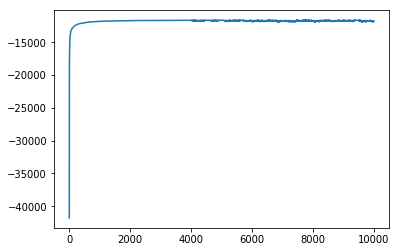

In [0]:
import matplotlib.pyplot as plt
plt.plot(equil_log_probs)

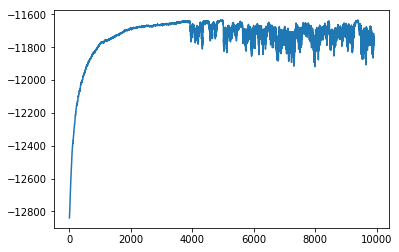

In [0]:
plt.plot(equil_log_probs[100:])

In [0]:
description = """
overdamped langevin with a stepsize of 0.001, collision rate of np.inf, run for 10000 steps on
a posterior density defined by a uniform prior and a gaussian likelihood

log prior: constant for radius in (1e-5, 5), scale_factor in (-10,10)
log likelihood: norm.logpdf(prediction, loc=expt_mean, scale=expt_uncertainty)

dataset: 631 molecules from freesolv

free energies estimated by one-sided exp with 25 vacuum snapshots per molecule

generated august 29, 2019 on google colab with https://colab.research.google.com/drive/1mS3qf3K-vQdy-s9cvOUkQZGFojtOJjcU#revisionId=0B0gq2iZsvdW6Z1NQamFTTlJ4SzA1VGdxbjBNV1ZsRGMrK0ljPQ
"""

In [0]:
onp.savez('langevin_gaussian.npz', description=description, types=types, equil_traj=onp.asarray(equil_traj), equil_log_probs=onp.asarray(equil_log_probs))

In [0]:
from google.colab import files
files.download('langevin_gaussian.npz')

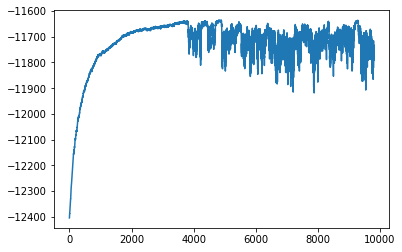

In [0]:
plt.plot(equil_log_probs[200:])

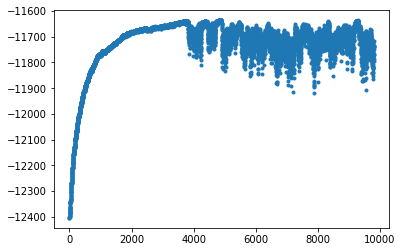

In [0]:
plt.plot(equil_log_probs[200:], '.')

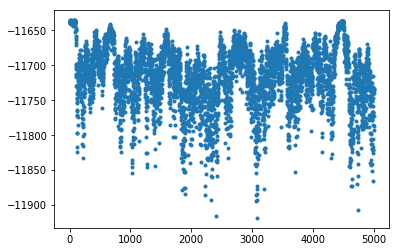

In [0]:
plt.plot(equil_log_probs[5000:], '.')

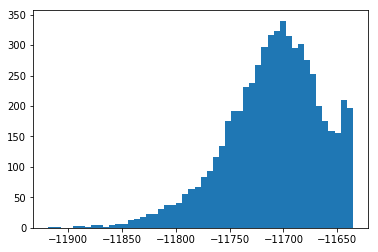

In [0]:
plt.hist(equil_log_probs[4000:], bins=50);

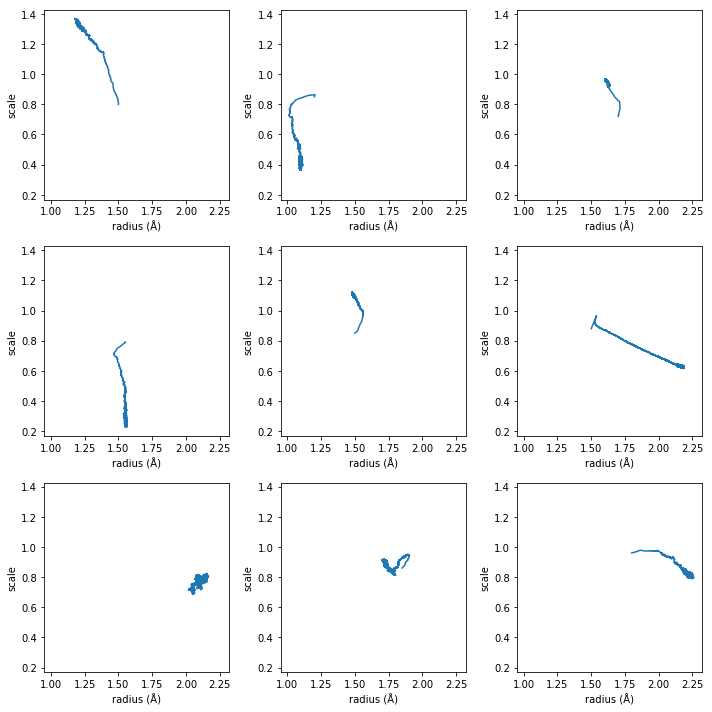

In [0]:
ax = None
plt.figure(figsize=(10,10))
for i in range(n_types):
    ax = plt.subplot(3,3,i+1, sharex=ax, sharey=ax)
    plt.plot(equil_traj[:,i], equil_traj[:,i + n_types])
    plt.xlabel('radius (Å)')
    plt.ylabel('scale')
plt.tight_layout()

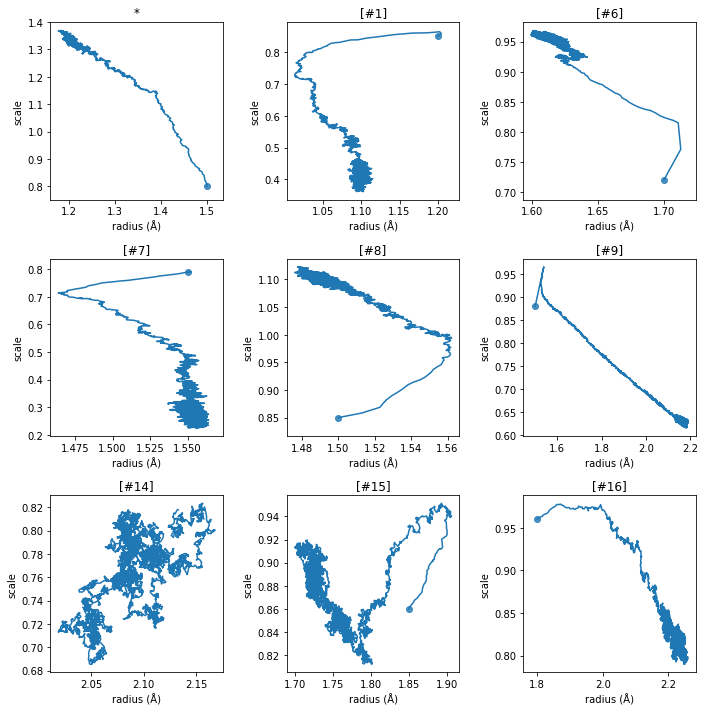

In [0]:
plt.figure(figsize=(10,10))
for i in range(n_types):
    ax = plt.subplot(3,3,i+1)#, sharex=ax, sharey=ax)
    plt.title(types[i])
    plt.scatter([equil_traj[0,i]], [equil_traj[0,i + n_types]], alpha=0.8)
    plt.plot(equil_traj[:,i], equil_traj[:,i + n_types])
    plt.xlabel('radius (Å)')
    plt.ylabel('scale')
plt.tight_layout()
plt.savefig('MCMC_trajectory_from_start.png', dpi=300, bbox_inches='tight')


In [0]:
files.download('MCMC_trajectory_from_start.png')

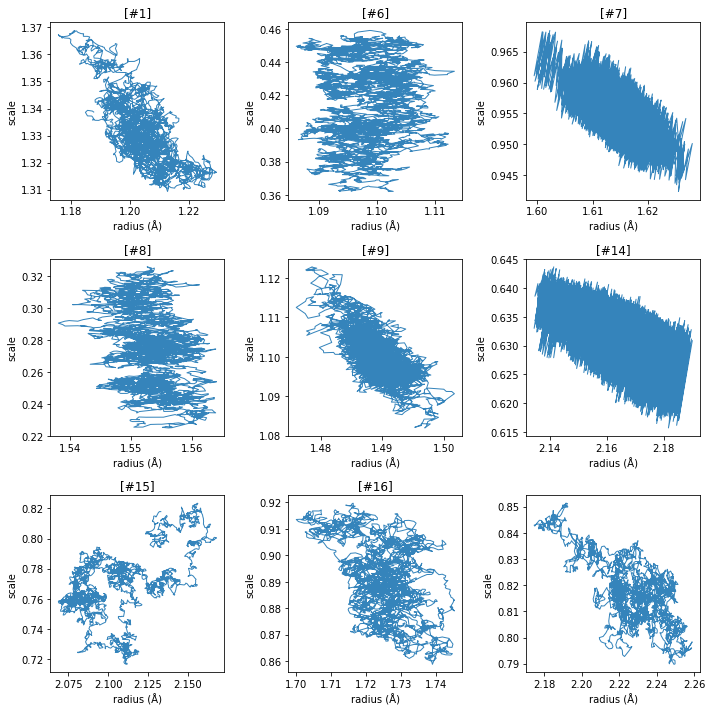

In [0]:
ax = None
plt.figure(figsize=(10,10))
for i in range(n_types):
    ax = None
    plt.title(types[i])
    ax = plt.subplot(3,3,i+1, sharex=ax, sharey=ax)
    plt.plot(equil_traj[5049:,i], equil_traj[5049:,i + n_types], linewidth=1, alpha=0.9)
    plt.xlabel('radius (Å)')
    plt.ylabel('scale')
plt.tight_layout()
plt.savefig('MCMC_trajectory_equilibrated.png', dpi=300, bbox_inches='tight')


In [0]:
files.download('MCMC_trajectory_equilibrated.png')

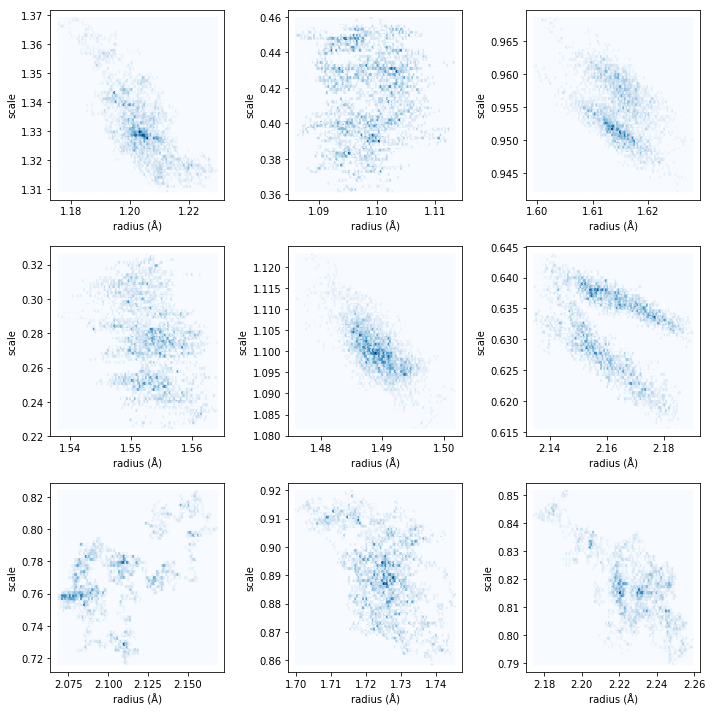

In [0]:
ax = None
plt.figure(figsize=(10,10))
for i in range(n_types):
    ax = None
    ax = plt.subplot(3,3,i+1, sharex=ax, sharey=ax)
    plt.hexbin(equil_traj[5000:,i], equil_traj[5000:,i + n_types], cmap='Blues')
    plt.xlabel('radius (Å)')
    plt.ylabel('scale')
plt.tight_layout()

## 3.2. [todo] Metropolis-Adjusted Langevin

To validate that the sampling bias is negligible, we can also use the Metropolis-adjusted Langevin Algorithm (MALA) to generate asymptotically unbiased samples...

Looking at the `equil_log_probs` trajectory, it does seem fishy after ~t=5000 -- I wonder if this is something to do with numerical instability...

## 3.3. Estimating equilibration time


In [0]:
!pip install pymbar

In [0]:
from pymbar import timeseries
t0, g, Neff_max = timeseries.detectEquilibration(onp.asarray(equil_log_probs))

In [0]:
t0, g, Neff_max

(5049, 79.213425, 62.52728)

In [0]:
samples = equil_traj[t0::int(round(g))]

In [0]:
samples.shape

(63, 18)

# 4. [WIP] Bayesian leave-one-out cross-validation by importance sampling

Importance-sampling leave-one-out cross-validation:
* Collect samples from the posterior distribution
* For each datapoint $i$
    * Reweight to posterior distribution defined with data point $i$ missing
    * Generate distribution of predictions from reweighted posterior distribution
    * Compute loss of that predictive distribution
    

References:
* Vehtari, A., Gelman, A., and Gabry, J. (2017). Practical Bayesian model evaluation using leave-one-out cross-validation and WAIC. Statistics and Computing. 27, 1413. doi:10.1007/s11222-016-9696-4. (preprint [arXiv:1507.04544](https://arxiv.org/abs/1507.04544))
* Piironen, J. & Vehtari, A. (2017). Comparison of Bayesian predictive methods for model selection. Statistics and Computing. 27, 711. [doi:10.1007/s11222-016-9649-y](https://link.springer.com/article/10.1007/s11222-016-9649-y) 


In [0]:
preds = np.array([get_predictions(s) for s in tqdm(equil_traj)])
print(preds.shape)

100%|██████████| 10001/10001 [03:41<00:00, 45.11it/s]


(10001, 631)


In [0]:
components = np.vstack([norm.logpdf(p, loc=expt_means, scale=expt_uncertainties) for p in preds])
components.shape

(10001, 631)

In [0]:
full_log_ll = components.sum(1)

In [0]:
loo_log_ll = full_log_ll - components[:,0]
loo_log_ll - full_log_ll

DeviceArray([ 40.03515625,  81.56640625, 124.05664062, ..., 140.87207031,
             159.41699219, 142.85546875], dtype=float32)

In [0]:
log_importance_weights = components
log_importance_weights

DeviceArray([[ -40.03402328,   -2.4982748,   -5.59038162, ...,
                -1.40703404,   -1.08424008,   -3.74235916],
             [ -81.56691742,   -6.27606726,   -6.39268064, ...,
                -1.43517685,   -0.93184841,   -1.2210182],
             [-124.05574799,  -10.31898975,   -7.09047556, ...,
                -1.36338341,   -1.06971645,   -0.97138143],
             ...,
             [-140.87220764,   -1.07378101,  -25.08291435, ...,
                -1.82747447,   -1.75773692,   -2.41069078],
             [-159.41653442,   -1.31302691,  -25.00645638, ...,
                -1.73392892,   -1.87466121,   -2.70556569],
             [-142.85546875,   -1.09148741,  -24.91171837, ...,
                -1.81541598,   -1.75824928,   -2.40106177]], dtype=float32)

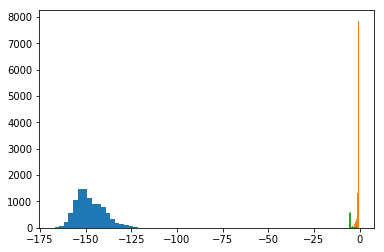

In [0]:
plt.hist(log_importance_weights[:,0], bins=50);
plt.hist(log_importance_weights[:,10], bins=50);
plt.hist(log_importance_weights[:,20], bins=50);

In [0]:
from pymbar import EXP
w = - onp.asarray(log_importance_weights)
EXP(w[:,0])

(138.19475520978997, 0.6511742803950336)

In [0]:
DeltaFs = onp.array([EXP(w[:,i], compute_uncertainty=False) for i in range(len(expt_means))])

(array([602.,  16.,   7.,   4.,   0.,   0.,   1.,   0.,   0.,   1.]),
 array([-7.23387586e-01,  8.74954424e+01,  1.75714272e+02,  2.63933102e+02,
         3.52151932e+02,  4.40370762e+02,  5.28589592e+02,  6.16808422e+02,
         7.05027252e+02,  7.93246082e+02,  8.81464912e+02]),
 <a list of 10 Patch objects>)

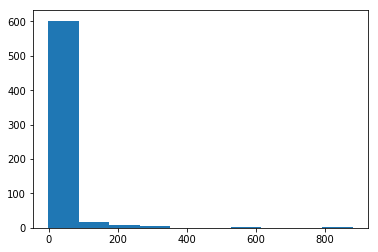

In [0]:
plt.hist(DeltaFs)

In [0]:
def get_normalized_weights(unnormalized_log_weights):
    Z = logsumexp(unnormalized_log_weights)
    w = np.exp(unnormalized_log_weights - Z)
    #assert(np.isclose(np.sum(w), 0))
    return w

In [0]:
weights = get_normalized_weights(- w[:,0])

In [0]:
weights.sum()

DeviceArray(1.0000001, dtype=float32)

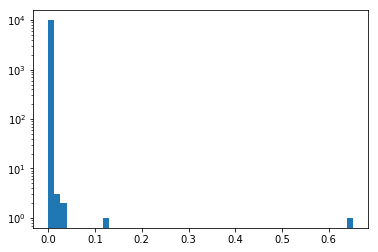

In [0]:
plt.hist(weights, bins=50);
plt.yscale('log')

In [0]:
i = 0
avg_pred = np.dot(weights, preds[:,i])
avg_pred

DeviceArray(-8.266169, dtype=float32)

In [0]:
expt_means[i] - avg_pred

DeviceArray(-0.08846378, dtype=float32)

In [0]:
expt_means[:10], expt_means[:10] * kj_mol_to_kT

(DeviceArray([ -8.35463238,  -7.74702311,  -1.2489754, -16.60799789,
               -4.05073118, -10.93697357,   1.80595088,  -5.78916979,
                3.08868241,  -7.24068165], dtype=float32),
 DeviceArray([-3.37021661, -3.12511015, -0.50383037, -6.69958258,
              -1.63404453, -4.41192007,  0.72851151, -2.3353219,
               1.24595892, -2.92085457], dtype=float32))

(array([ 2.,  1., 10.,  3., 14., 38., 27., 14., 12.,  6.]),
 array([-23.983704  , -21.006416  , -18.029129  , -15.051842  ,
        -12.074554  ,  -9.097267  ,  -6.1199794 ,  -3.1426923 ,
         -0.16540489,   2.8118825 ,   5.78917   ], dtype=float32),
 <a list of 10 Patch objects>)

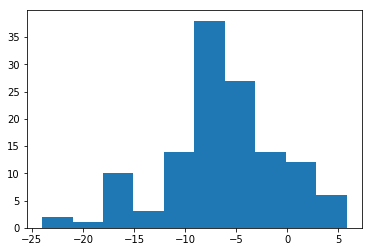

In [0]:
plt.hist(expt_means)

In [0]:
preds_kcal_mol = preds * kT_to_kcal_mol
expt_means_kcal_mol = expt_means * kT_to_kcal_mol
expt_uncertainties_kcal_mol = expt_uncertainties * kT_to_kcal_mol

train_residuals = (preds_kcal_mol - expt_means_kcal_mol)
train_residuals.shape

(10001, 631)

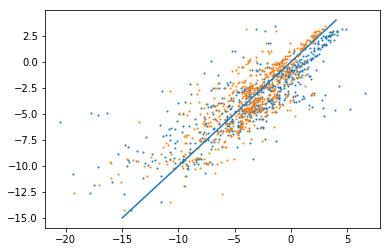

In [0]:
plt.scatter(preds_kcal_mol[0], expt_means_kcal_mol, s=1)
plt.scatter(preds_kcal_mol[-1], expt_means_kcal_mol, s=1)
plt.plot(np.arange(-15,5), np.arange(-15,5))

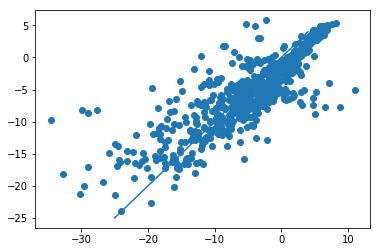

In [0]:
plt.scatter(preds[0], expt_means)
plt.plot(np.arange(-25,5), np.arange(-25,5))

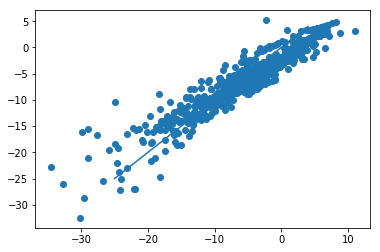

In [0]:
plt.scatter(preds[0], preds[-1])
plt.plot(np.arange(-25,5), np.arange(-25,5))

In [0]:
avg_preds = preds[t0:].mean(0)

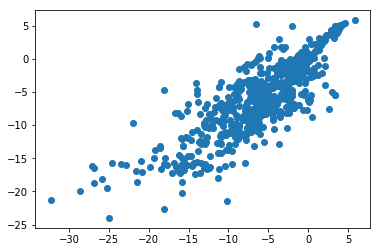

In [0]:
plt.scatter(avg_preds, expt_means)

In [0]:
posterior_avg_rmse = np.sqrt(np.mean((kT_to_kcal_mol * (avg_preds - expt_means))**2))
posterior_avg_rmse

DeviceArray(2.0148427, dtype=float32)

Text(0.5, 0, 'iteration')

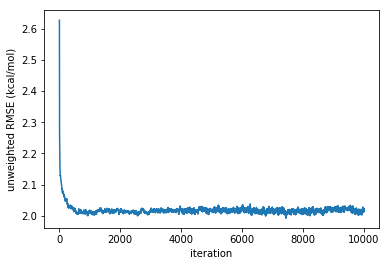

In [0]:
train_rmses = np.sqrt(np.mean((train_residuals)**2, 1))
plt.plot(train_rmses)
plt.ylabel('unweighted RMSE (kcal/mol)')
plt.xlabel('iteration')

Text(0.5, 0, 'iteration - $t_0$')

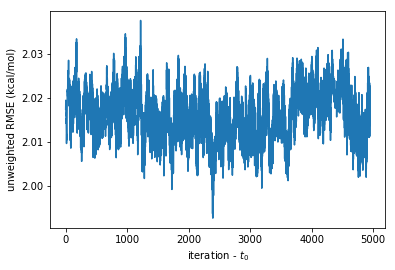

In [0]:
plt.plot(train_rmses[t0:])
plt.ylabel('unweighted RMSE (kcal/mol)')
plt.xlabel('iteration - $t_0$')

In [0]:
min(train_rmses)

1.9926777

# 5. Checking for spurious local minima

## 5.1. Gradient descent from MCMC snapshots

In [0]:
def gradient_descent(jac, x0, stepsize, num_iters, callback=None):
    """

    Parameters
    ----------
    x0
    jac : callable, with signature jac(x)
    stepsize
    n_steps
    callback: callable, with signature callback(x, i, g)

    Returns
    -------

    """
    traj = [x0]
    for i in tqdm(range(num_iters)):
        g = jac(traj[-1])
        traj.append(traj[-1] - stepsize * g)
        if np.isnan(traj[-1]).any():
            print('NaN encountered!')
            return traj
        if not (callback is None):
            callback(traj[-1], i, g)
    return traj

In [0]:
len(samples)

63

In [0]:
gd_trajs = [gradient_descent(lambda x : - grad_log_posterior(x), s, 0.0000001, 200) for s in samples]

100%|██████████| 200/200 [00:22<00:00,  8.86it/s]


In [0]:
gd_preds = [np.array([get_predictions(s) for s in tqdm(gd_traj)]) for gd_traj in gd_trajs]

100%|██████████| 201/201 [00:04<00:00, 45.43it/s]


In [0]:
gd_rmses = onp.asarray([np.sqrt(np.mean((gd_pred * kT_to_kcal_mol - expt_means_kcal_mol)**2, 1)) for gd_pred in gd_preds]).T

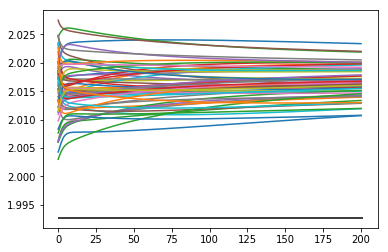

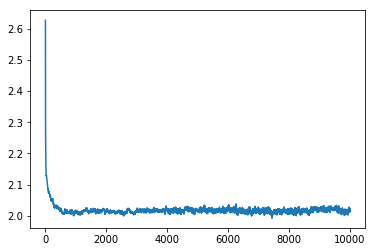

In [0]:
plt.plot(gd_rmses)
plt.hlines(min(train_rmses), 0, len(gd_rmses))
plt.figure()
plt.plot(train_rmses)

### Figure: MCMC density with GD trajectories


In [0]:
onp.savez('gd_trajs_gaussian.npz', gd_trajs=onp.asarray(gd_trajs))

In [0]:
files.download('gd_trajs_gaussian.npz')

In [0]:
gd_trajs_array = onp.asarray(gd_trajs)
gd_trajs_array.shape

(63, 201, 18)

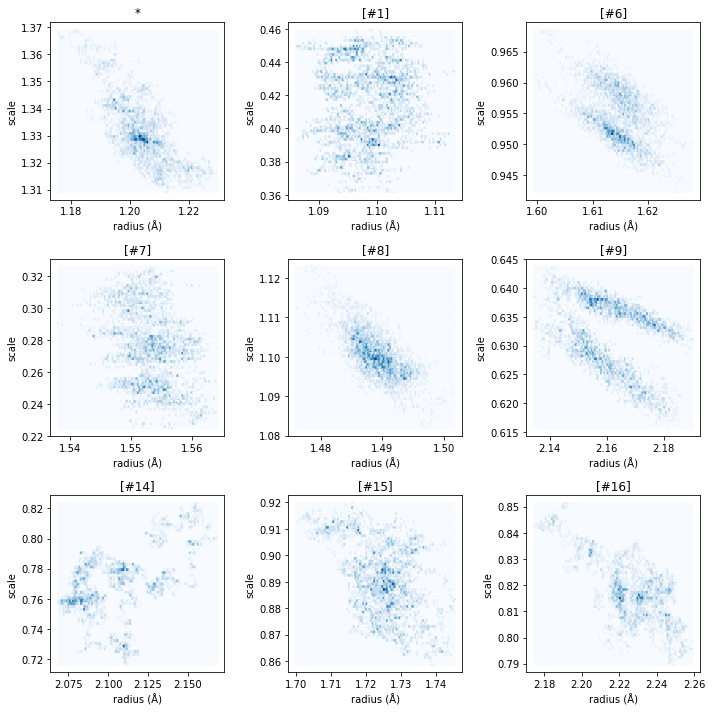

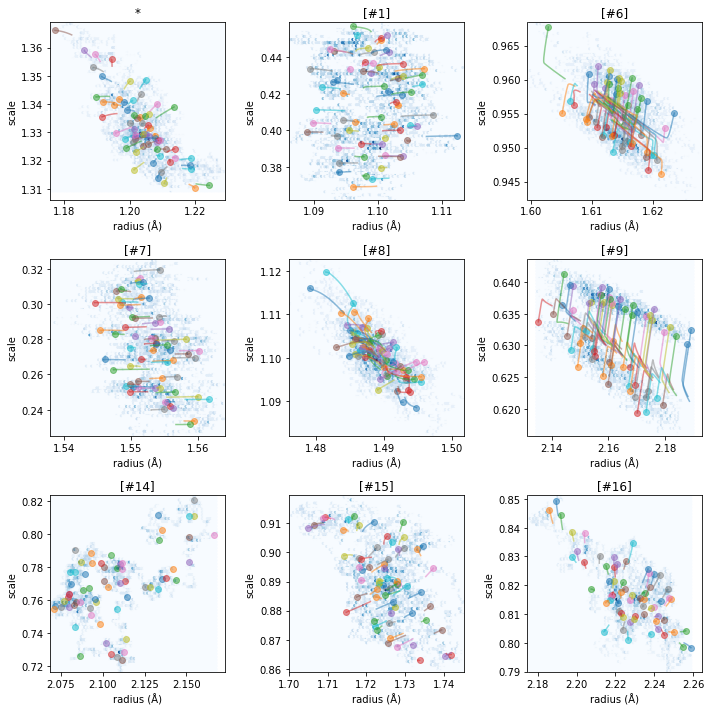

In [0]:
def plot_2d_marginals(with_gd_trajs=True):
    plt.figure(figsize=(10,10))
    for i in range(n_types):
        ax = plt.subplot(3,3,i+1)
        plt.title(types[i])

        # MCMC density
        plt.hexbin(equil_traj[t0:,i], equil_traj[t0:,i + n_types], cmap='Blues')
        if with_gd_trajs:
            # GD trajs
            for traj in gd_trajs_array:
                plt.scatter([traj[0,i]], traj[0,i+n_types], alpha=0.5)
                plt.plot(traj[:,i], traj[:,i+n_types], alpha=0.5)

        plt.xlabel('radius (Å)')
        plt.ylabel('scale')
    plt.tight_layout()
plot_2d_marginals(with_gd_trajs=False)
plt.savefig('mcmc_density.png', dpi=300, bbox_inches='tight')

plot_2d_marginals(with_gd_trajs=True)
plt.savefig('mcmc_density_w_gd_trajs.png', dpi=300, bbox_inches='tight')


In [0]:
files.download('mcmc_density.png')
files.download('mcmc_density_w_gd_trajs.png')

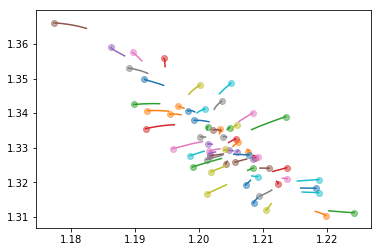

In [0]:
i = 0
for traj in gd_trajs_array:
    plt.scatter([traj[0,i]], traj[0,i+n_types], alpha=0.5)
    plt.plot(traj[:,i], traj[:,i+n_types])

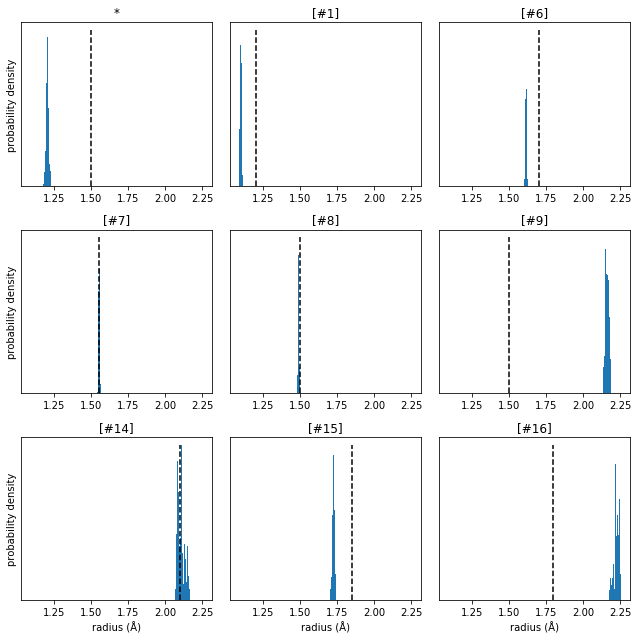

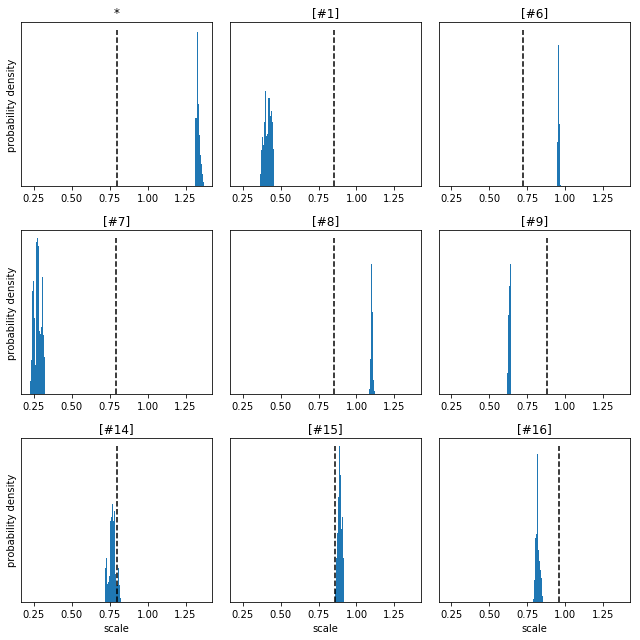

In [0]:
def plot_radius_histograms(samples):
    ax = None
    plt.figure(figsize=(9,9))
    for i in range(n_types):
        ax = plt.subplot(3,3,i+1,sharex=ax)
        bins = plt.hist(samples[:,i], bins=50)[0];
        if i > 5:
            plt.xlabel('radius (Å)')
        if i % 3 == 0:
            plt.ylabel('probability density')
        plt.yticks([])
        plt.title(types[i])
        plt.vlines(theta[i], 0, max(bins), linestyles='--')
    plt.tight_layout()

def plot_scale_histograms(samples):
    ax = None
    plt.figure(figsize=(9,9))
    for i in range(n_types):
        ax = plt.subplot(3,3,i+1,sharex=ax)
        bins = plt.hist(samples[:,i + n_types], bins=50)[0];
        if i > 5:
            plt.xlabel('scale')
        if i % 3 == 0:
            plt.ylabel('probability density')
        plt.yticks([])
        plt.vlines(theta[i + n_types], 0, max(bins), linestyles='--')
        plt.title(types[i])
    plt.tight_layout()
    
plot_radius_histograms(equil_traj[t0:])
plt.savefig('radius_histograms.png', dpi=300, bbox_inches='tight')
plot_scale_histograms(equil_traj[t0:])
plt.savefig('scale_histograms.png', dpi=300, bbox_inches='tight')

In [0]:
files.download('radius_histograms.png')
files.download('scale_histograms.png')